# Regional residual separation example

This code illustrates how to compute the regional residual separation of gravity disturbance data by using simple and robust polynomial fits (Beltrão et al., 1991).

* Beltrão, J. F., Silva, J. B. C., and Costa, J. C., (1991). Robust polynomial fitting method for regional gravity estimation, GEOPHYSICS, 56(1), 80-89. [doi: 10.1190/1.1442960](http://dx.doi.org/10.1190/1.1442960)

### Things we have to import

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import prism
import plot_functions as plf

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# density of each prism (in kg/m³)
density = np.array([1000, 
                    2000, 1200, 
                    900])

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
yp = np.linspace(area[0], area[1], shape[0])
xp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([yp, xp, zp])

### Synthetic residual field

In [4]:
# Compute the vertical component of acceleration
gz = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

### Synthetic regional field

In [5]:
X = xp-np.mean(xp)
Y = yp-np.mean(yp)
regional_gz = -20 - 1e-3*X + 1e-3*Y + 1e-8*X*X + 1e-8*Y*Y

total_gz = regional_gz + gz

### Plot the data

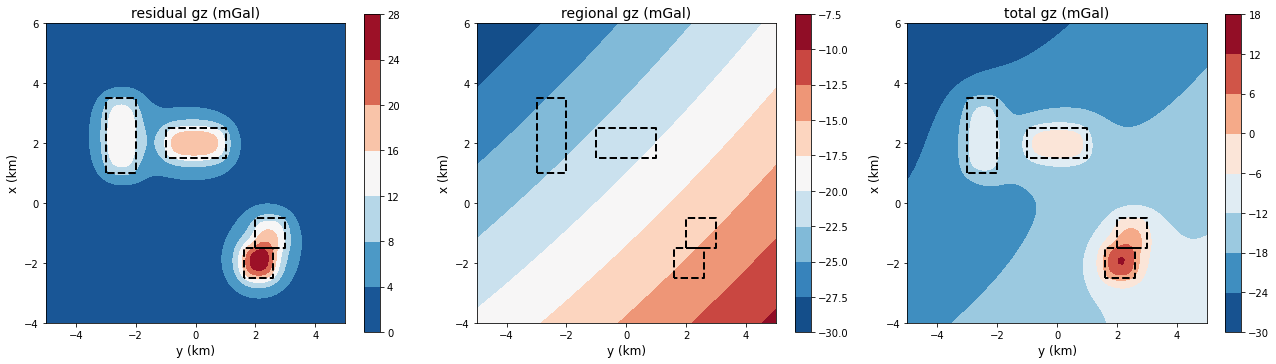

In [7]:
fields = [gz, regional_gz, total_gz]
windows = [1, 2, 3]
titles = ['residual gz (mGal)', 'regional gz (mGal)', 'total gz (mGal)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the regional field - simple polynomial fit

In [8]:
# Matrix defining the regional polynomial
#A = np.polynomial.polynomial.polyvander2d(x=yp, y=xp, deg=[1,1])
A = np.vstack([np.ones(xp.size), yp, xp, yp*yp, xp*xp]).T

In [9]:
# Estimate the coefficients of the polynomial 
# representing the regional field
ATA = np.dot(A.T,A)
ATd = np.dot(A.T,total_gz)
p_simple = np.linalg.solve(ATA, ATd)

In [10]:
# Estimated regional field
estimated_regional_gz_simple = np.dot(A, p_simple)

diff_regional_simple = estimated_regional_gz_simple - regional_gz

In [11]:
# Estimated residual field
estimated_residual_gz_simple = total_gz - estimated_regional_gz_simple

diff_residual_simple = estimated_residual_gz_simple - gz

#### Plot the results

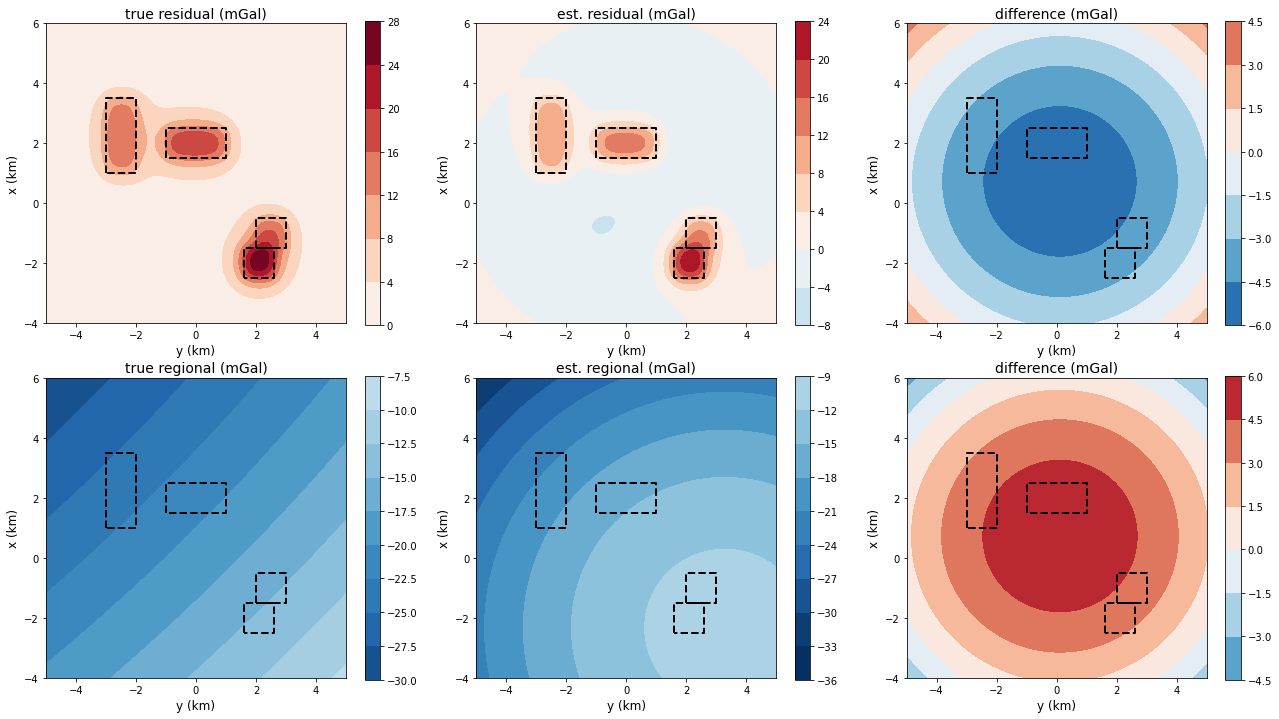

In [12]:
fields = [gz, estimated_residual_gz_simple, diff_residual_simple,
          regional_gz, estimated_regional_gz_simple, diff_regional_simple]
windows = [1, 2, 3, 4, 5, 6]

ranges_residual = np.max([np.abs(gz), np.abs(estimated_residual_gz_simple)])
ranges_regional = np.max([np.abs(regional_gz), np.abs(estimated_regional_gz_simple)])
ranges = [ranges_residual, ranges_residual, 7,
          ranges_regional, ranges_regional, 7]


titles = ['true residual (mGal)', 'est. residual (mGal)', 'difference (mGal)',
          'true regional (mGal)', 'est. regional (mGal)', 'difference (mGal)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r',
                 vmin=-ranges[w], vmax=ranges[w])
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the regional field - robust polynomial fit

In [13]:
# Matrix defining the regional polynomial
#A = np.polynomial.polynomial.polyvander2d(x=yp, y=xp, deg=[1,1])
A = np.vstack([np.ones(xp.size), yp, xp, yp*yp, xp*xp]).T

In [14]:
# Estimate the coefficients of the polynomial 
# representing the regional field by using a simple
# polynomial fit (Least squares)
#ATA = np.dot(A.T,A)
#ATd = np.dot(A.T,total_gz)
#p_simple = np.linalg.solve(ATA, ATd)

iterations = 10

p_robust = p_simple.copy()
estimated_regional_gz_robust = estimated_regional_gz_simple.copy()

for i in range(iterations):
    r = total_gz - estimated_regional_gz_robust
    s = np.median(r)
    W = np.diag(np.exp(-((0.6745*r/s)**2.)))
    #W = np.diag(1./np.abs(r + 1.e-10))
    W = np.dot(A.T,W)
    p_robust = np.linalg.solve(np.dot(W,A), np.dot(W,total_gz))
    estimated_regional_gz_robust = np.dot(A, p_robust)

In [15]:
# Estimated regional field
estimated_regional_gz_robust = np.dot(A, p_robust)

diff_regional_robust = estimated_regional_gz_robust - regional_gz

In [16]:
# Estimated residual field
estimated_residual_gz_robust = total_gz - estimated_regional_gz_robust

diff_residual_robust = estimated_residual_gz_robust - gz

#### Plot the results

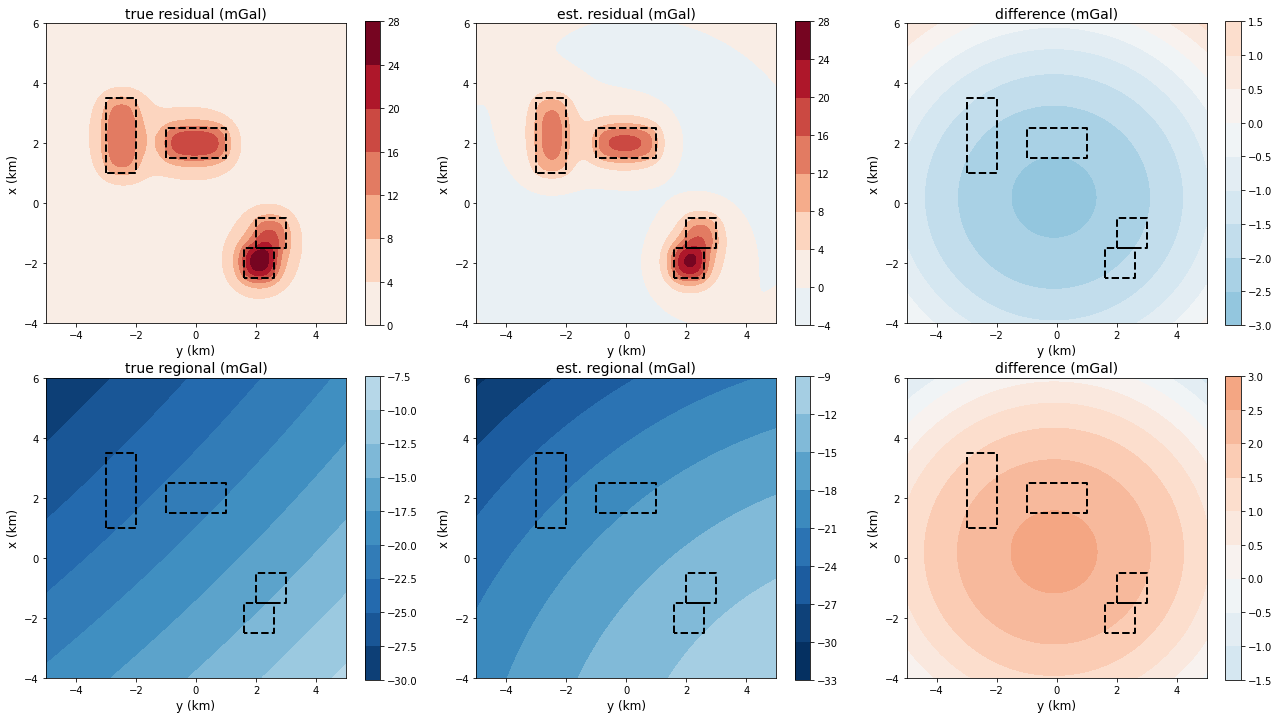

In [17]:
fields = [gz, estimated_residual_gz_robust, diff_residual_robust,
          regional_gz, estimated_regional_gz_robust, diff_regional_robust]
windows = [1, 2, 3, 4, 5, 6]

ranges_residual = np.max([np.abs(gz), np.abs(estimated_residual_gz_robust)])
ranges_regional = np.max([np.abs(regional_gz), np.abs(estimated_regional_gz_robust)])
ranges = [ranges_residual, ranges_residual, 7,
          ranges_regional, ranges_regional, 7]


titles = ['true residual (mGal)', 'est. residual (mGal)', 'difference (mGal)',
          'true regional (mGal)', 'est. regional (mGal)', 'difference (mGal)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r',
                 vmin=-ranges[w], vmax=ranges[w])
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()